In [102]:
# Import required packages
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] ="false"


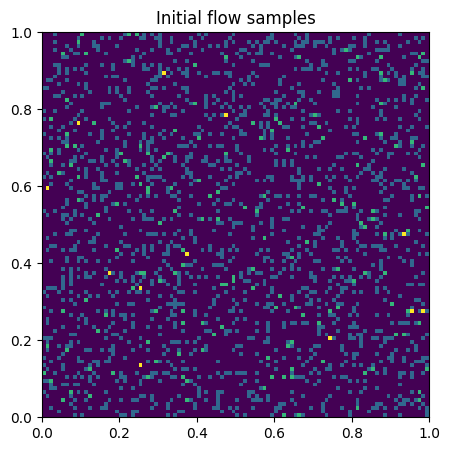

Array(0.00018895, dtype=float32)

In [103]:

import jax
import jax.random as jr
import jax.numpy as jnp
from flax import nnx
import optax
from learning.module.bijx.autoregressive import make_autoregressive_nsf_bijx
from matplotlib import pyplot as plt

data_key, flow_key, train_key, sample_key = jr.split(jr.key(0), 4)
rngs = nnx.Rngs(params=0, sample=1)
ndim=2
bins = 16  # same as Zuko's `bins`
hidden = (64, 64)
n_transforms = 3
low = jnp.array([-.0, -.0])
high = jnp.array([1, 1.0])
seed= 100
# low = jnp.array([-3.0, -3.0])
# high = jnp.array([3, 3.0])
# low = jnp.array([-7.0, -7.0])
# high = jnp.array([7, 7.0])
dist_bijx = make_autoregressive_nsf_bijx(
    ndim=ndim,
    bins=16,
    hidden_features=(64, 64),
    n_transforms=3,
    seed=seed,
    domain_range=(low, high),
)

import optax
tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(1e-3, weight_decay=1e-4), # Adds weight decay for regularization
)
optimizer = nnx.Optimizer(
    dist_bijx,
    tx,
    wrt=nnx.Param,
)

# Sampling:
key = jax.random.PRNGKey(seed)
contexts, logq = dist_bijx.sample(batch_shape=(2048,), rng=key)
plt.figure(figsize=(5, 5))
plt.hist2d(contexts[:, 0], contexts[:, 1], bins=100, range=[[low[0], high[0]], [low[1], high[1]]])
plt.title("Initial flow samples")
plt.show()
logq2 = dist_bijx.log_density(x=contexts)
jnp.abs(logq-logq2).sum()


/tmp/ipykernel_1440573/297318697.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))


Saved GIF to NF_NeuralSpline_training.gif


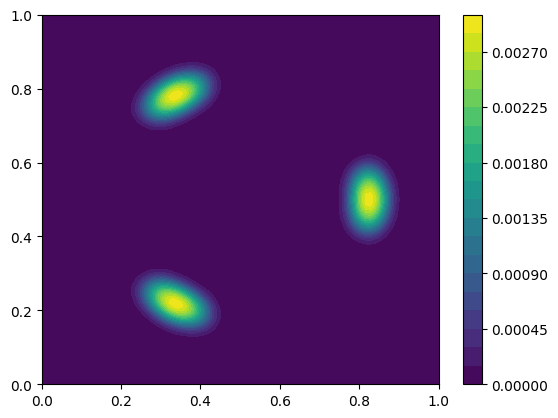

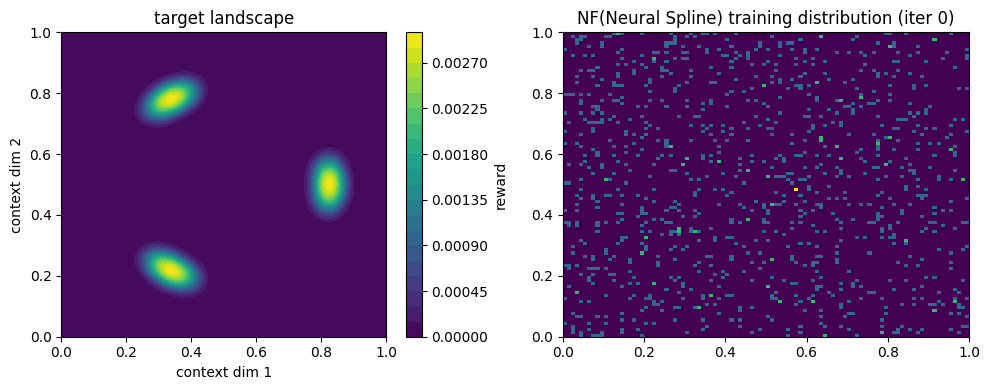

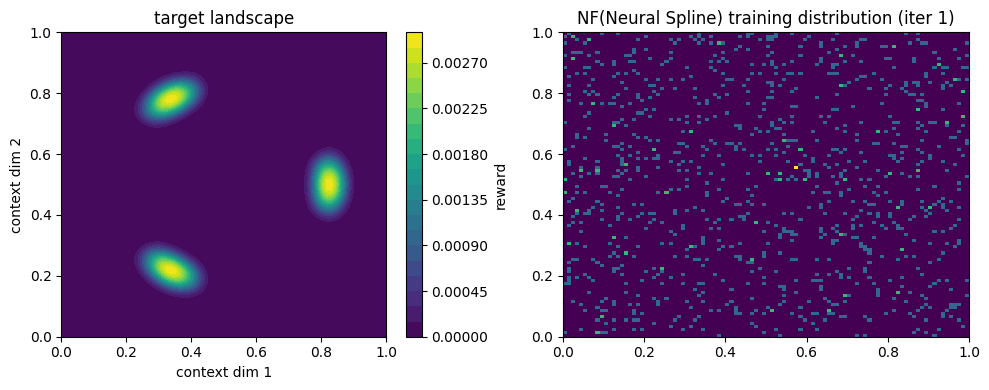

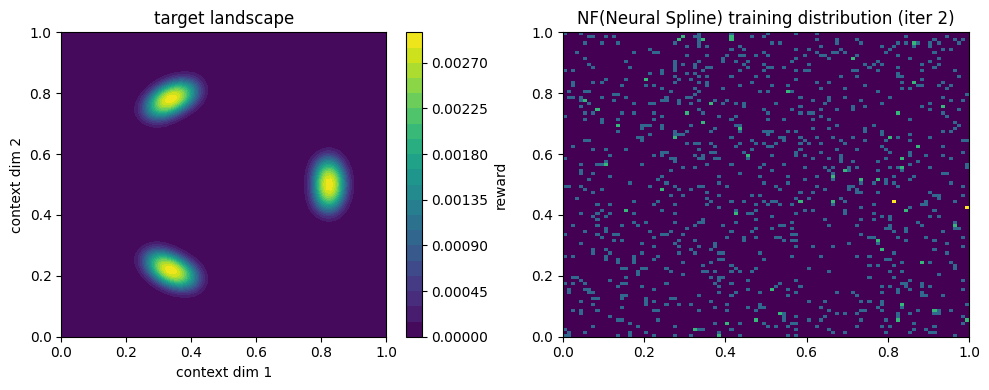

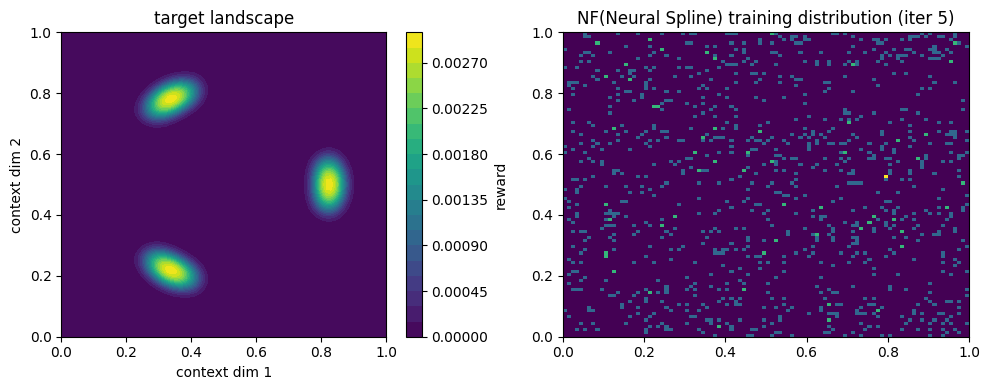

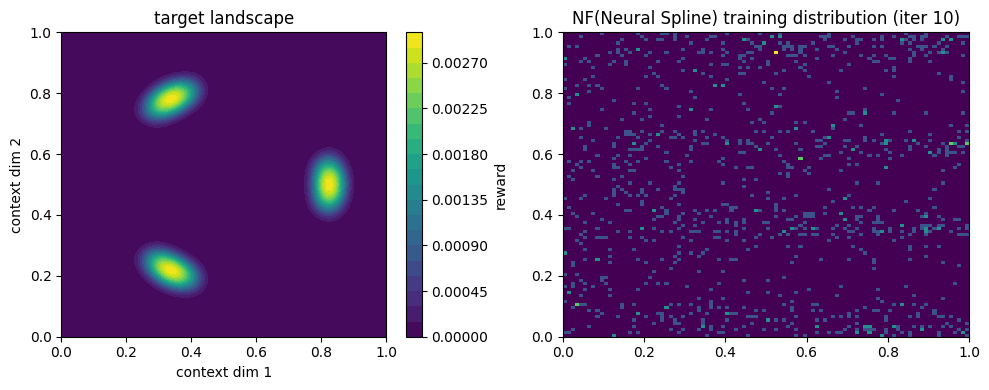

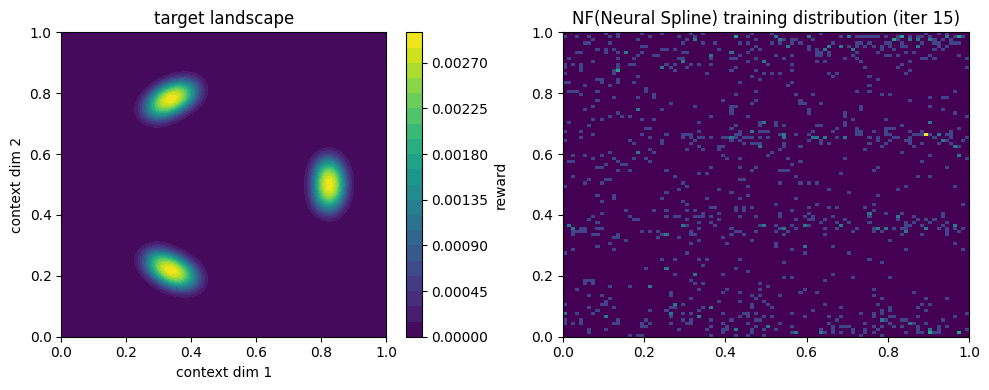

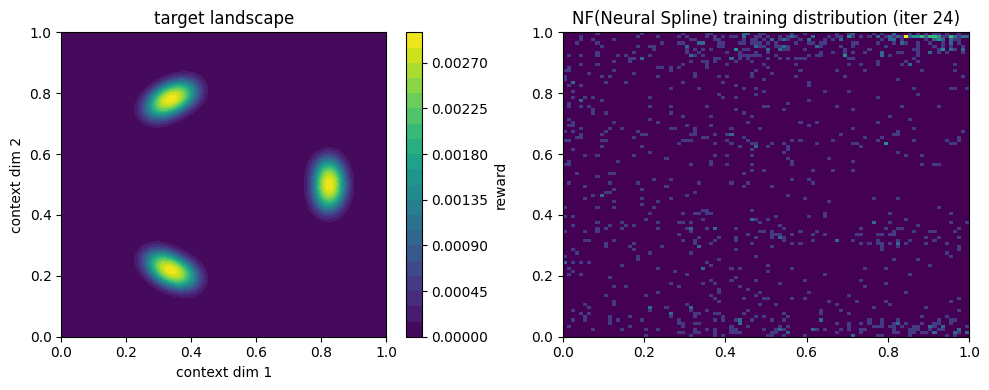

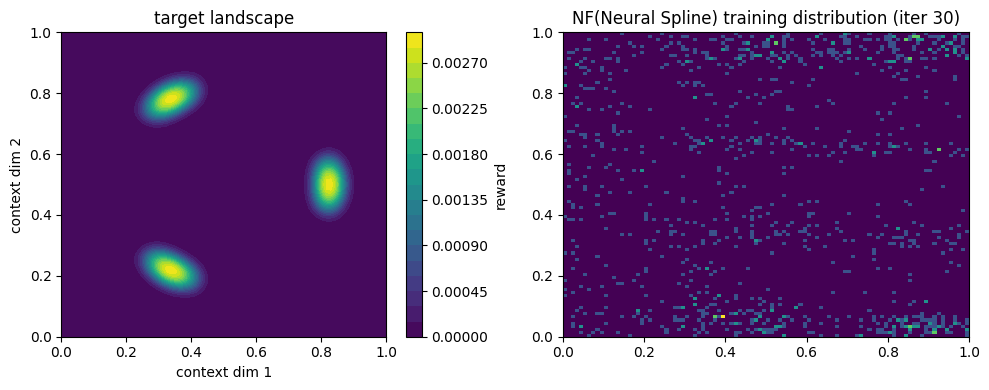

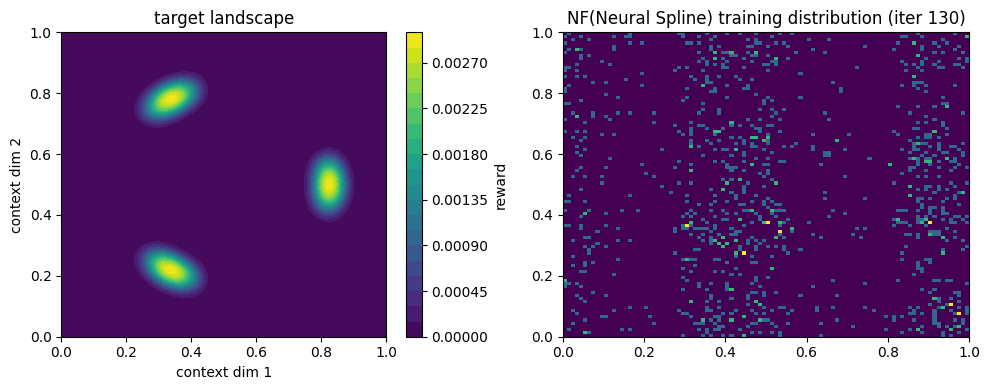

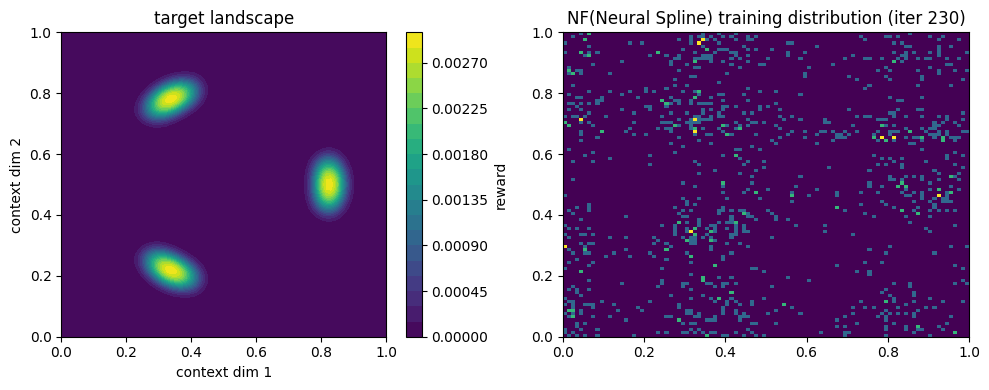

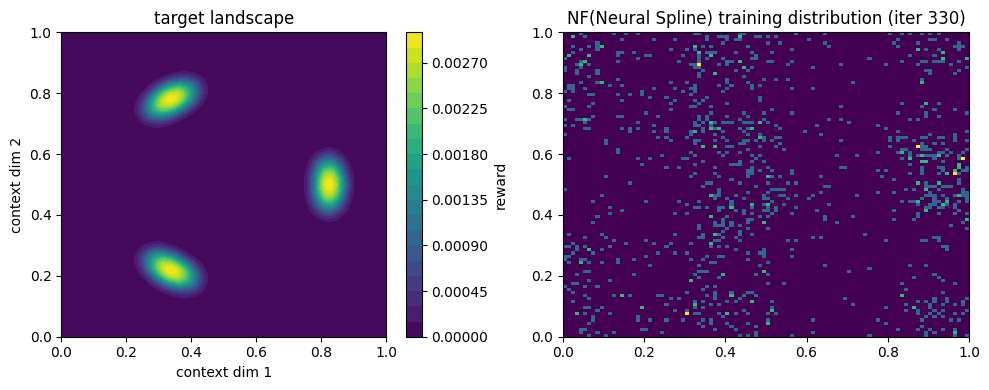

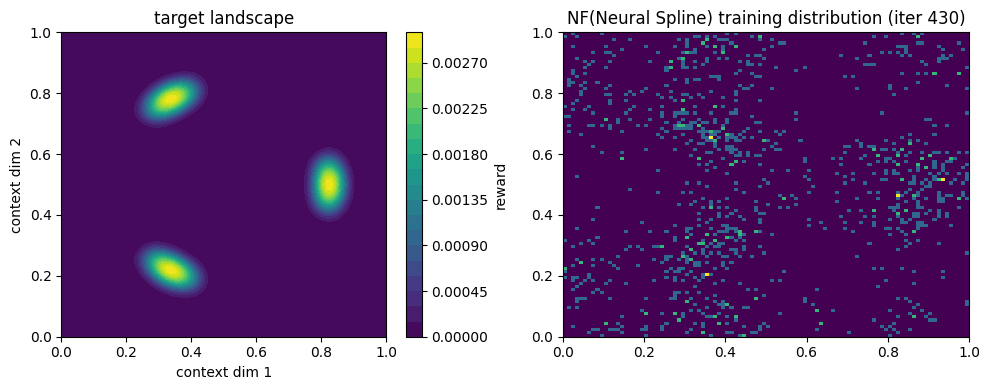

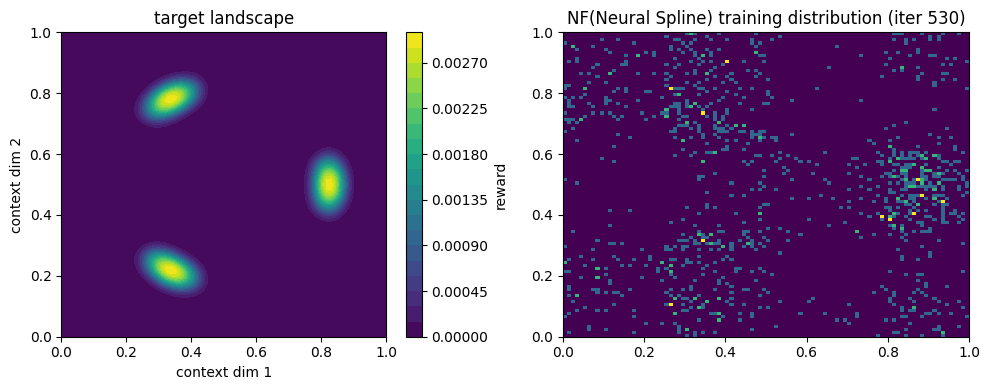

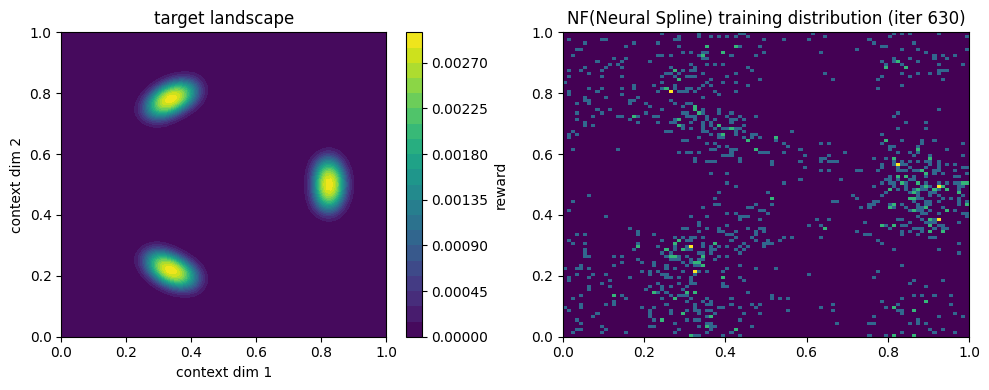

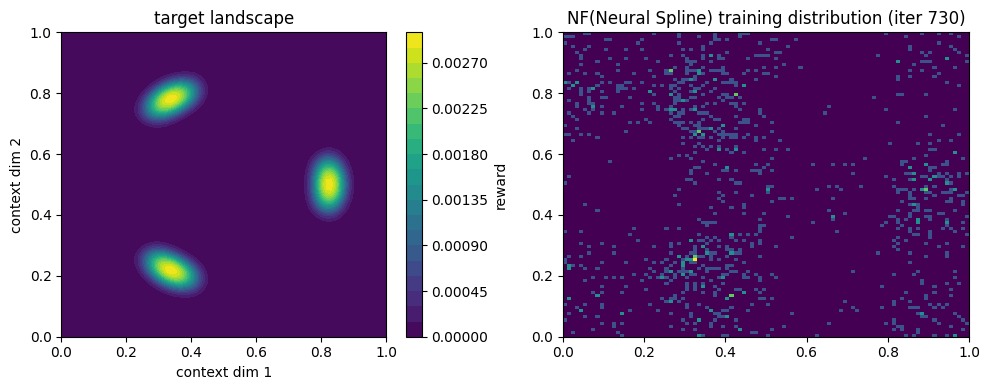

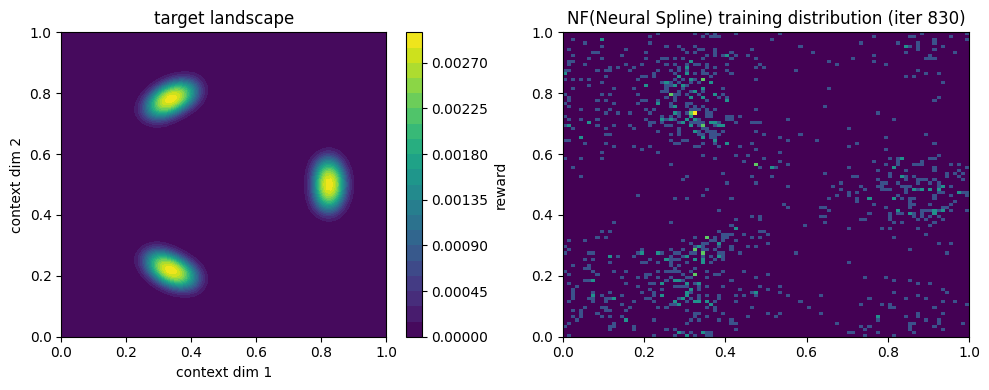

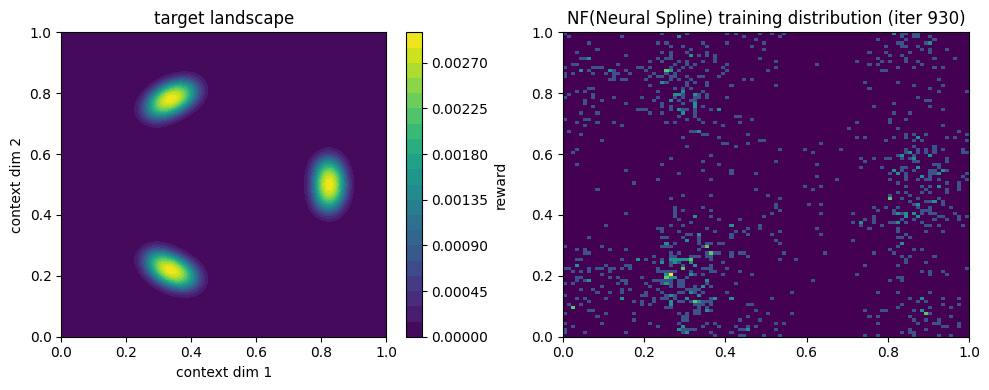

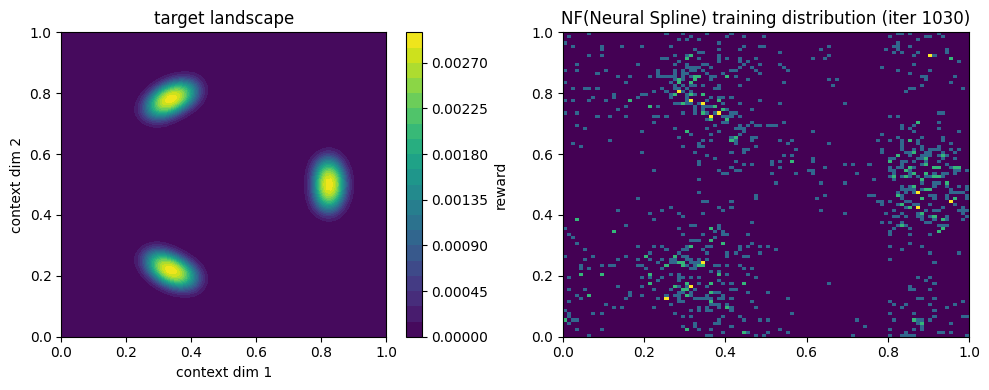

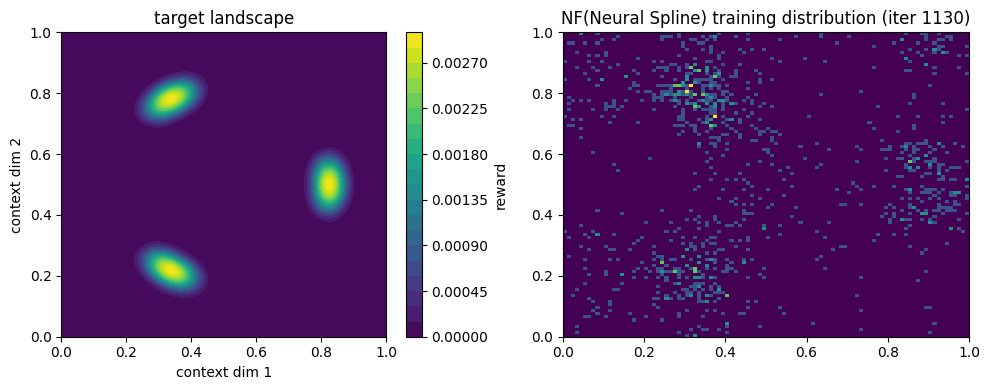

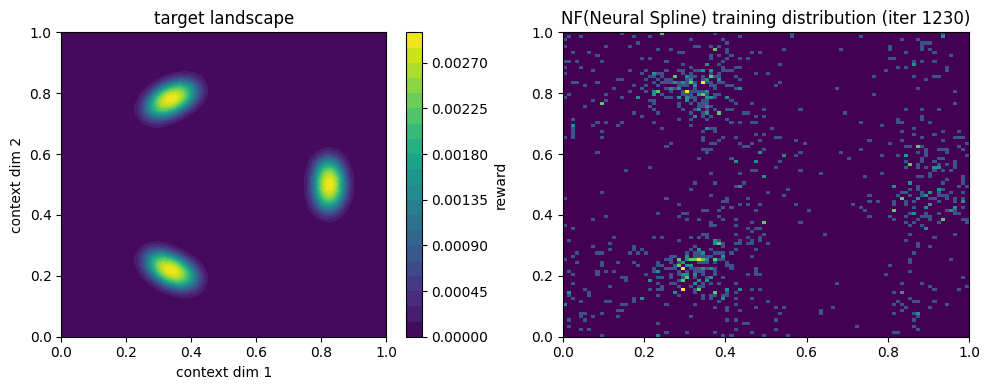

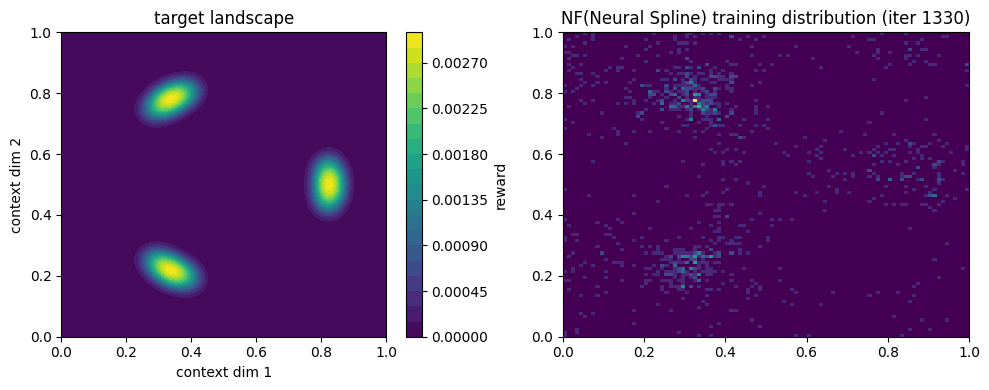

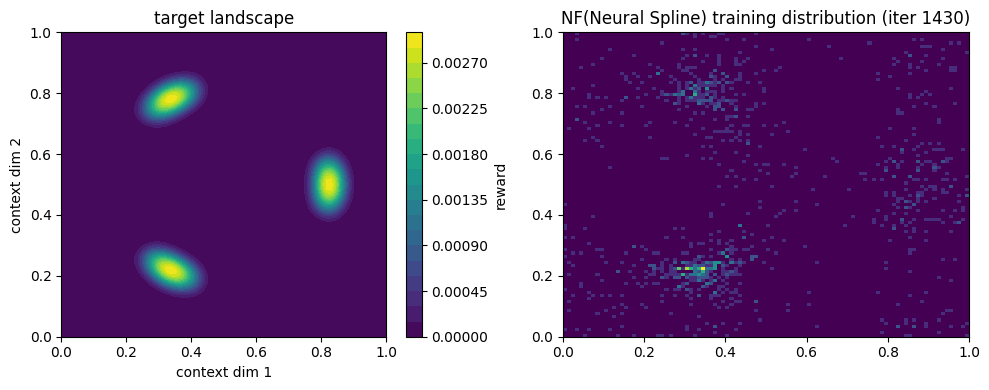

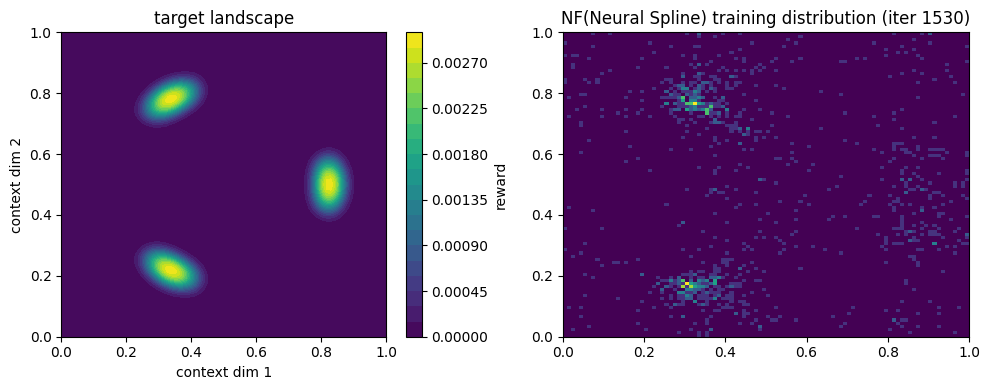

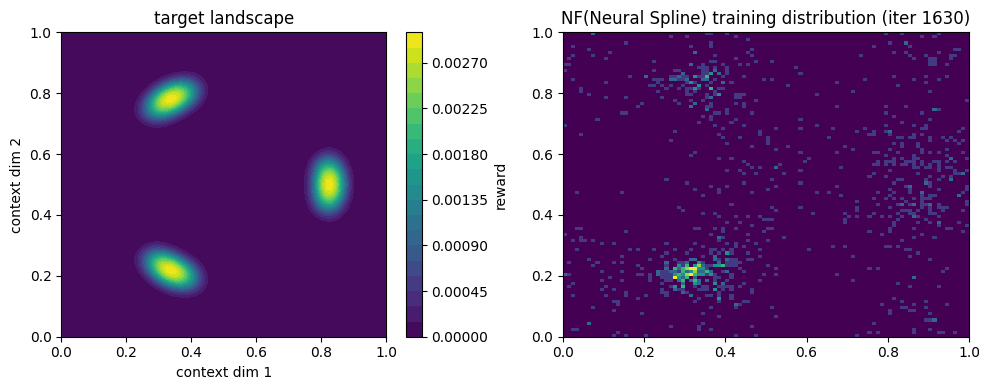

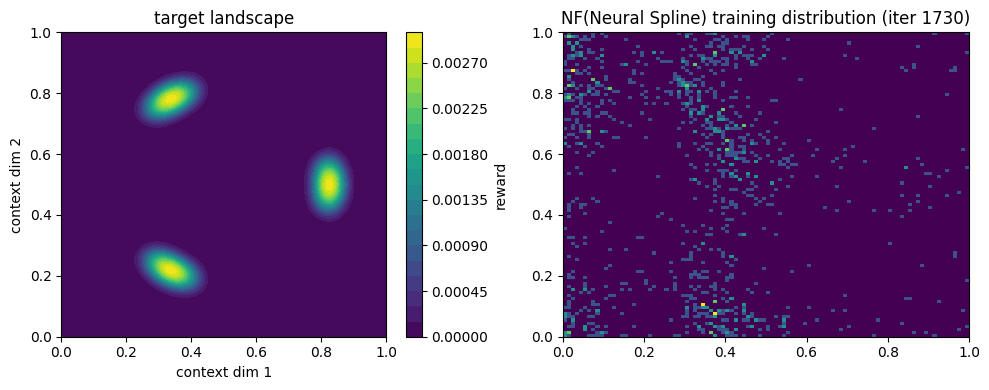

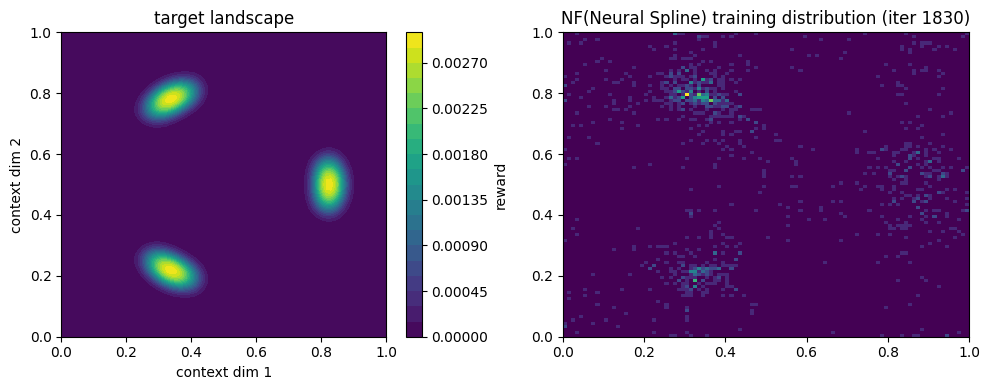

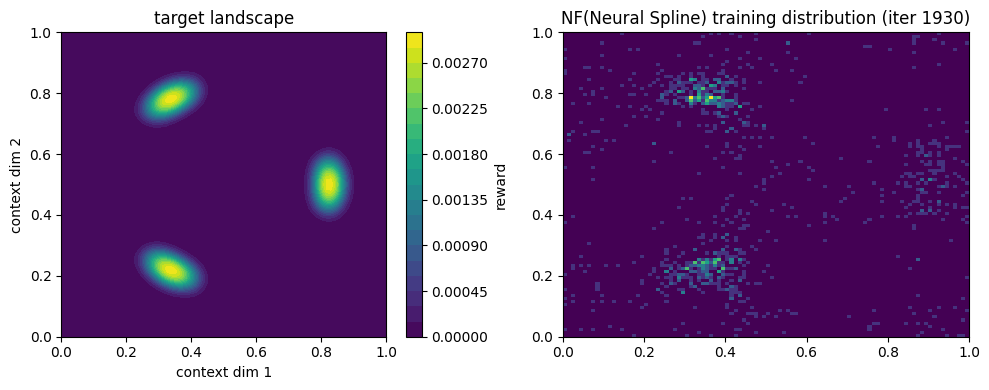

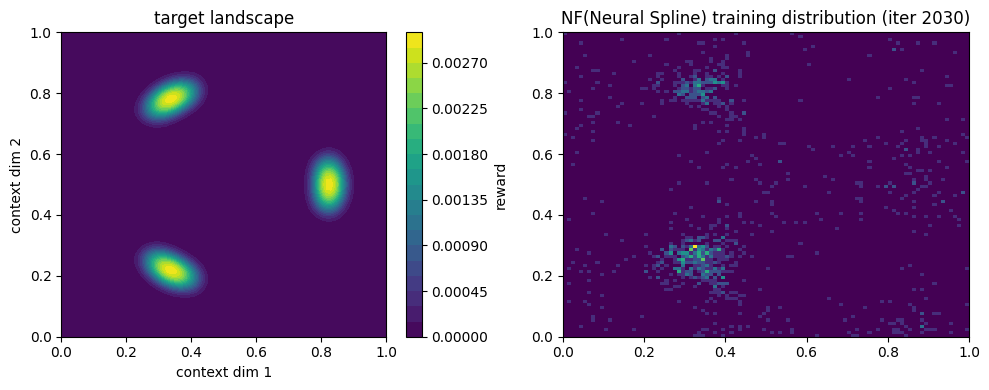

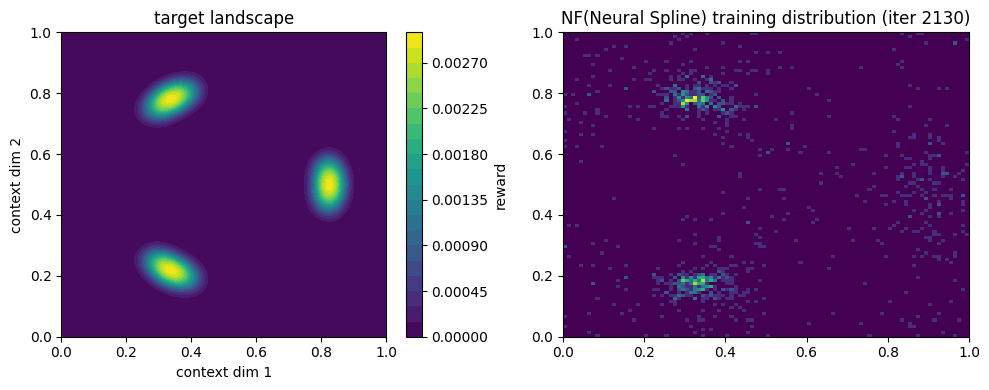

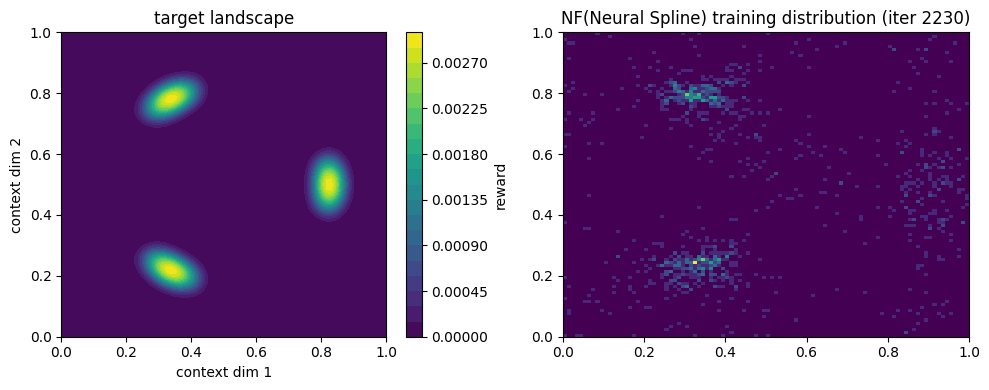

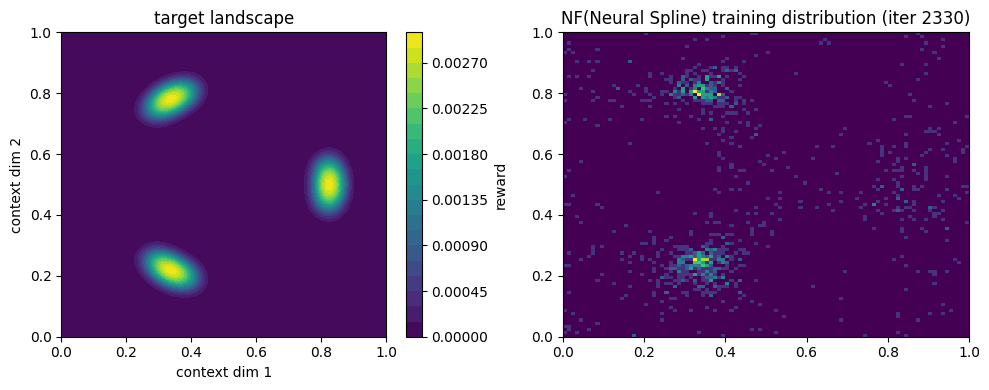

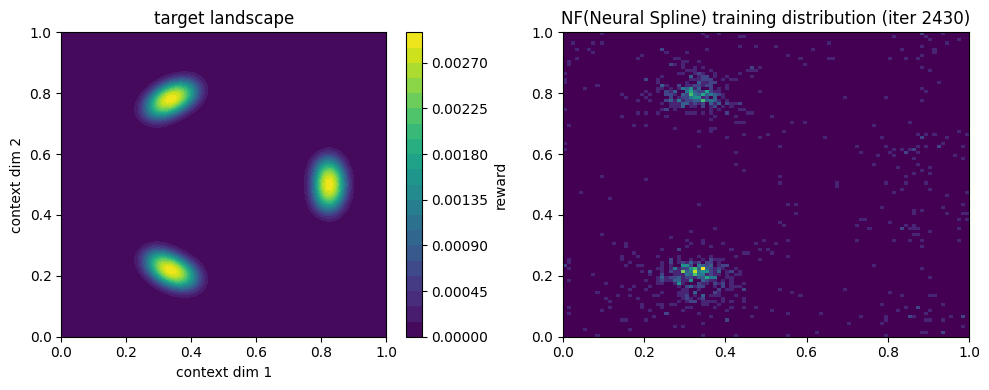

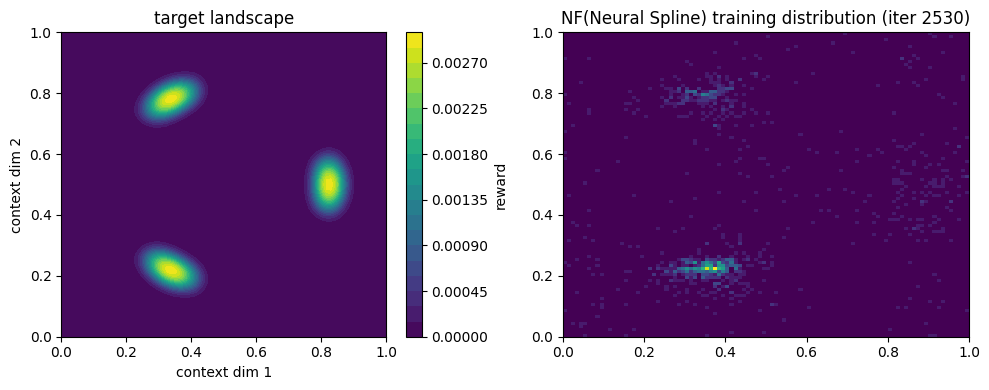

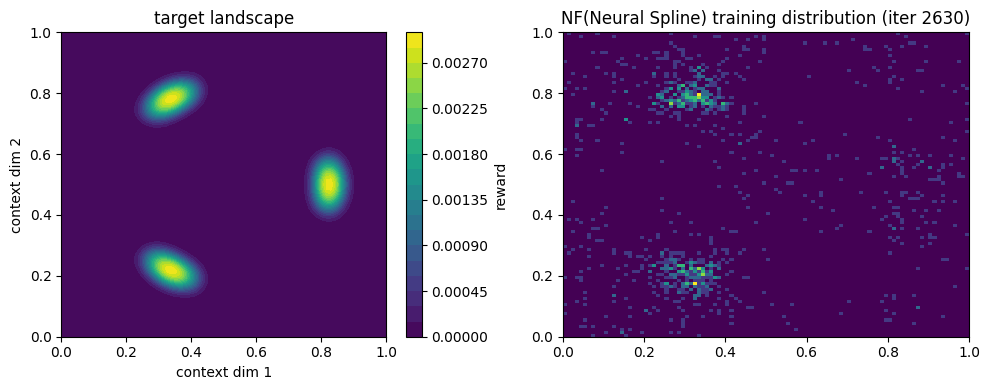

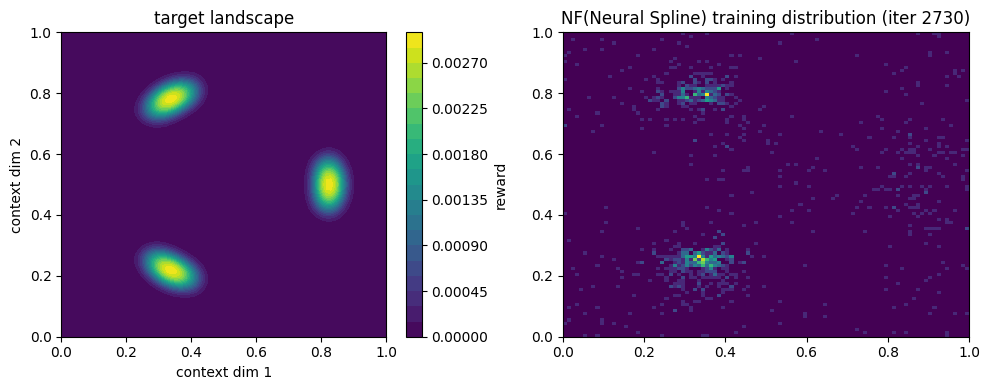

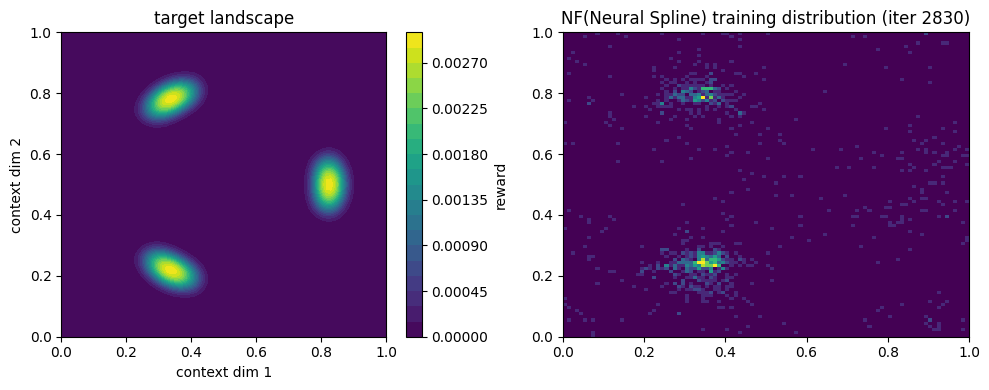

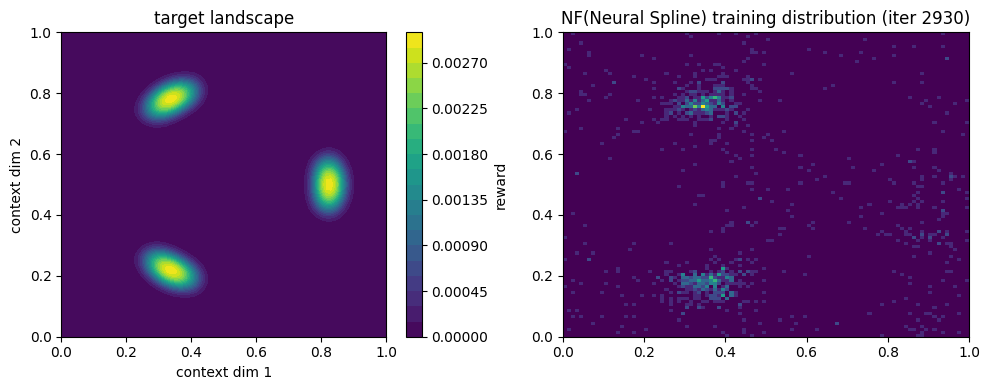

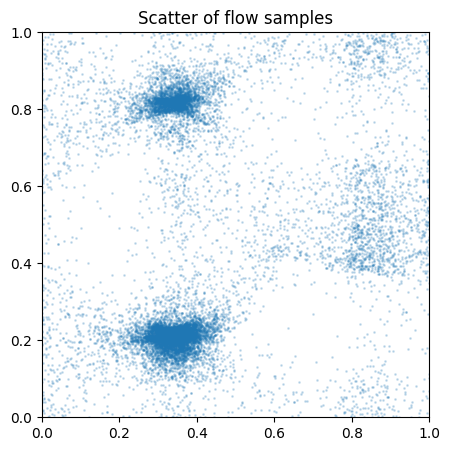

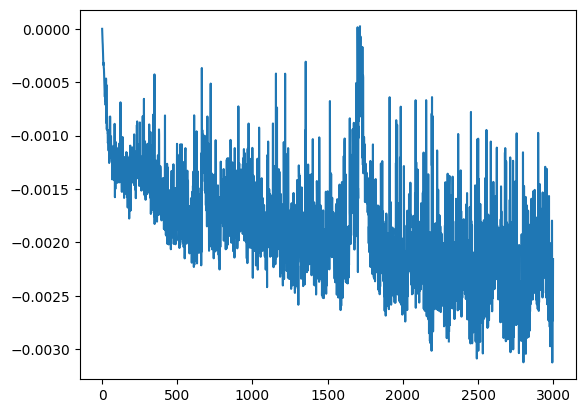

In [104]:
import jax, jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import imageio
import optax
def target0(contexts, target=jnp.array([0.3, 0.7]), sigma=0.12, noise_std=0.2, key=None):
    # reward in [0,1], peaked near target
    diff = contexts - target[None, :]
    r = jnp.exp(-0.5 * jnp.sum((diff / sigma) ** 2, axis=-1))
    if key is not None:
        r = jnp.clip(r + noise_std * jax.random.normal(key, r.shape), 0.0, 1.0)
    logr =  jnp.log(r + 1e-10)
    return jax.nn.log_softmax(logr)
def target1(x):
    # Mixture of two Gaussians
    mean1 = jnp.array([1.0, 0.4])
    cov1 = 0.3 * jnp.array([[1.0, 0.3], [0.3, 1.0]])

    mean2 = jnp.array([-1.0, -0.4])
    cov2 = 0.1 * jnp.array([[1.0, -0.3], [-0.3, 1.0]])

    pdf1 = jax.scipy.stats.multivariate_normal.pdf(x, mean1, cov1)
    pdf2 = jax.scipy.stats.multivariate_normal.pdf(x, mean2, cov2)

    return jnp.log(0.4 * pdf1 + 0.6 * pdf2)
def target2(z):
    z1, z2 = jnp.split(z, 2, axis=-1)
    norm = jnp.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = jnp.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = jnp.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - jnp.log(exp1 + exp2)

    return -u

beta = -10
gamma = .0
def target3(z):
    m=3
    r0=0.65
    sr=0.12
    X, Y = jnp.split(z, 2, axis=-1)
    x = 2.0 * (X - 0.5)
    y = 2.0 * (Y - 0.5)
    r = jnp.hypot(x, y)
    theta = jnp.arctan2(y, x)

    ring = jnp.exp(-0.5 * ((r - r0) / sr) ** 2)
    petals = jnp.cos(m * theta)
    U = jnp.tanh(1.6 * (ring * petals))  # bounded in (-1, 1)
    log_unnorm = -beta * U.squeeze() 
    regularization_weight = .01
    log_prior = -0.5 * regularization_weight * jnp.sum(z**2, axis=-1)

    # --- 3. Combine ---
    return jax.nn.log_softmax(log_unnorm) #stabilization
target = target3

volume = jnp.prod(high - low)
N = 2 **10
@nnx.jit
def train_step(model, model_old, optimizer, key):
    kr, kc1, kc2 = jax.random.split(key, 3)
    graphdef, prev_state = nnx.split(model)
    
    def loss_fn(model):
        # 1. Sample from current model (q_new)
        contexts, logq = model.sample((N,), rng=kc1)
        
        # 2. Compute log_prob of these samples under the OLD model (q_old)
        # We assume model_old has a similar log_density method
        samples_prev, logq_old = model_old.sample((1000,), rng=kc2)
        logq_current = model.log_density(x=samples_prev)
        # --- Original Loss Logic ---
        logp = target(contexts)
        log_weights = logq - jax.lax.stop_gradient(logp)
        log_weights = jax.nn.log_softmax(log_weights)
        weights = jnp.exp(log_weights)
        importance_weights = weights / jnp.sum(weights)
        original_loss = (importance_weights * logq).mean()
        
        # --- Proximal Term (KL Divergence) ---
        # KL(q_old || q_current) = E_old [ log_q_old - log_q_current ]
        # We stop gradient on logq_old because we don't update the old model
        kl_div = jax.lax.stop_gradient(logq_old) - logq_current
        proximal_loss = gamma * jnp.mean(kl_div)
        
        return original_loss + proximal_loss

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(model=model, grads=grads)
    model_old = nnx.merge(graphdef, prev_state)
    return loss

def run_toy_corner(model, flow_opt):
    x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
    grid = jnp.c_[x.ravel(), y.ravel()]
    pdf_values = target(grid)
    pdf_values = jnp.exp(pdf_values)
    pdf_values = jnp.reshape(pdf_values, x.shape)
    T = 3000
    snap_iters = [0, 1, 2, 5, 10, 15, 24] + list(range(30, T, 100))
    # snap_iters = []
    key = jax.random.PRNGKey(0)
    gif_frames = [] 
    loss_hist = []
    graphdef, state = nnx.split(model)
    model_old = nnx.merge(graphdef, state)
    for t in range(T):
        kplot, ktrain, key = jax.random.split(key, 3)
        loss = train_step(model, model_old, flow_opt, ktrain)
        loss_hist.append(loss)
        if t in snap_iters:
            fig, (ax_reward, ax_NF) = plt.subplots(1, 2, figsize=(10, 4))
            ctf = ax_reward.contourf(x, y, pdf_values, levels=20)
            ax_reward.set_title("target landscape")
            ax_reward.set_xlabel("context dim 1")
            ax_reward.set_ylabel("context dim 2")
            z, _= model.sample(batch_shape=(1024,), rng=kplot)
            fig.colorbar(ctf, ax=ax_reward, label="reward")
            ax_NF.hist2d(z[:, 0].flatten(), z[:, 1].flatten(), (100, 100), #range=[[-3, 3], [-3, 3]])
                    range=[[low[0], high[0]], [low[1], high[1]]])
            ax_NF.set_title(f"NF(Neural Spline) training distribution (iter {t})")
            fig.tight_layout()
            fig.canvas.draw()
            frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
            gif_frames.append(frame)
            # plt.close(fig)
            # z, _= model.sample((2**20,), rng=kplot)  # Sample 1000 points
            # plt.figure(figsize=(10,10))
            # plt.hist2d(z[:, 0].flatten(), z[:, 1].flatten(), (100, 100), #range=[[-3, 3], [-3, 3]])
            #         range=[[low[0]-1, high[0]+1], [low[1]-1, high[1]+1]])


    if gif_frames:
        imageio.mimsave("NF_NeuralSpline_training.gif", gif_frames, fps=4)
        print("Saved GIF to NF_NeuralSpline_training.gif")
    key = jax.random.PRNGKey(0)
    x, _ = model.sample(batch_shape=(2**14,), rng=key)
    x_np = np.array(x)
    np.save(f"ns_samples_beta={beta}.npy", x_np)
    # 1) Raw scatter plot (no binning)
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.2)
    plt.xlim(low[0], high[0])
    plt.ylim(low[1], high[1])
    plt.title("Scatter of flow samples")
    plt.savefig(f"NS_image_beta={beta}.png")
    plt.show()
    
    # 2) Coarse 2D histogram to kill striping
    # plt.figure(figsize=(5, 5))
    # plt.hist2d(x[:, 0], x[:, 1], bins=40, range=[[low[0], high[0]], [low[1], high[1]]])
    # plt.title("Flow samples hist2d, coarse bins")
    # plt.show()
    loss_plot = np.array(loss_hist)
    plt.plot(loss_plot)
x, y = jnp.meshgrid(jnp.linspace(low[0], high[0], 100), jnp.linspace(low[1], high[1], 100))
grid = jnp.c_[x.ravel(), y.ravel()]
pdf_values = target(grid)
pdf_values = jnp.exp(pdf_values)
pdf_values = jnp.reshape(pdf_values, x.shape)
fig = plt.figure()
ctf = plt.contourf(x, y, pdf_values, levels=20, cmap='viridis')
cbar = fig.colorbar(ctf)
# ax = render_flow_pdf_2d_subplots(
#                 log_prob_fn=lambda x : dist_bijx.log_density(x=x),
#                 low=low,
#                 high=high,
#             )
run_toy_corner(dist_bijx, optimizer)


In [105]:
contexts, logq = dist_bijx.sample(batch_shape=(2048,), rng=key)
logq2 = dist_bijx.log_density(x=contexts)
jnp.abs(logq-logq2).sum()


Array(0.301525, dtype=float32)